In this notebook, we do a systematic training of a 2-layer GCN to predict X1 data from a single corresponding X2 value at the same time tnstant in the following manner:
* train on a single data point
* train on 2 data points to ensure we can fit/overfit 
* train on 3 data points 
* ...
* train on 100 data points, at which point we split into train and val sets 
* add more and more data and hopefully it gets better and better at generalizing to unseen data 


We are following the suggestion from this [stackexchange post](https://stats.stackexchange.com/questions/261704/training-a-neural-network-for-regression-always-predicts-the-mean). 

### imports and setup

In [124]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [125]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [126]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from lorenz import lorenzDataset, lorenzDatasetWrapper, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

In [127]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


## systematically train the model

### 2 data points 
(we start with 2 because we want >1 data points so the std!=0, which would mess with the normalization function. In the initial condition, the X2 variable has no perturbation.)

#### prepare data

In [198]:
# only uncomment each line if testing a non-default parameter
dataset_2 = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=2,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    K=6,
    # F=8,
    # c=10,
    # b=10,
    h=0.5,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=True,
    train_pct=
    1,  # no train/val split since we have so few data points and just want to ensure overfitting right now
    val_pct=0,
    test_pct=0,
    override=True)


generating new Lorenz data and saving to file
generating paired data
starting integration
reading Lorenz data from stored file
dataset_raw lorenzDataset(n_graphs=102)
time to concat: 0:00:00.000364
time to get std&mean: 0:00:00.000188


In [199]:
dataset_2.buffer

lorenzDataset(n_graphs=100)

In [200]:
dataset_2.train

lorenzDataset(n_graphs=2)

In [201]:
dataset_2.train[0].x.flatten()

array([-1.3651012 , -1.92622969, -0.71758297, -0.5274722 ,  0.00673184,
       -1.36907341])

In [202]:
dataset_2.train[1].x.flatten()

array([-1.26321839, -1.78820989, -0.83929783, -0.42305451, -0.04272093,
       -1.50721276])

In [203]:
dataset_2.train[0].y.flatten()

array([-3.51604188, -1.50290905, -1.74014372, -1.20552283, -0.24329053,
        0.35577363])

In [204]:
dataset_2.train[1].y.flatten()

array([-3.55845943, -1.26142977, -1.73481442, -1.21643471, -0.23477326,
        0.24076264])

inspect data

plotting train
no val data to plot
no training data to plot
editing legend


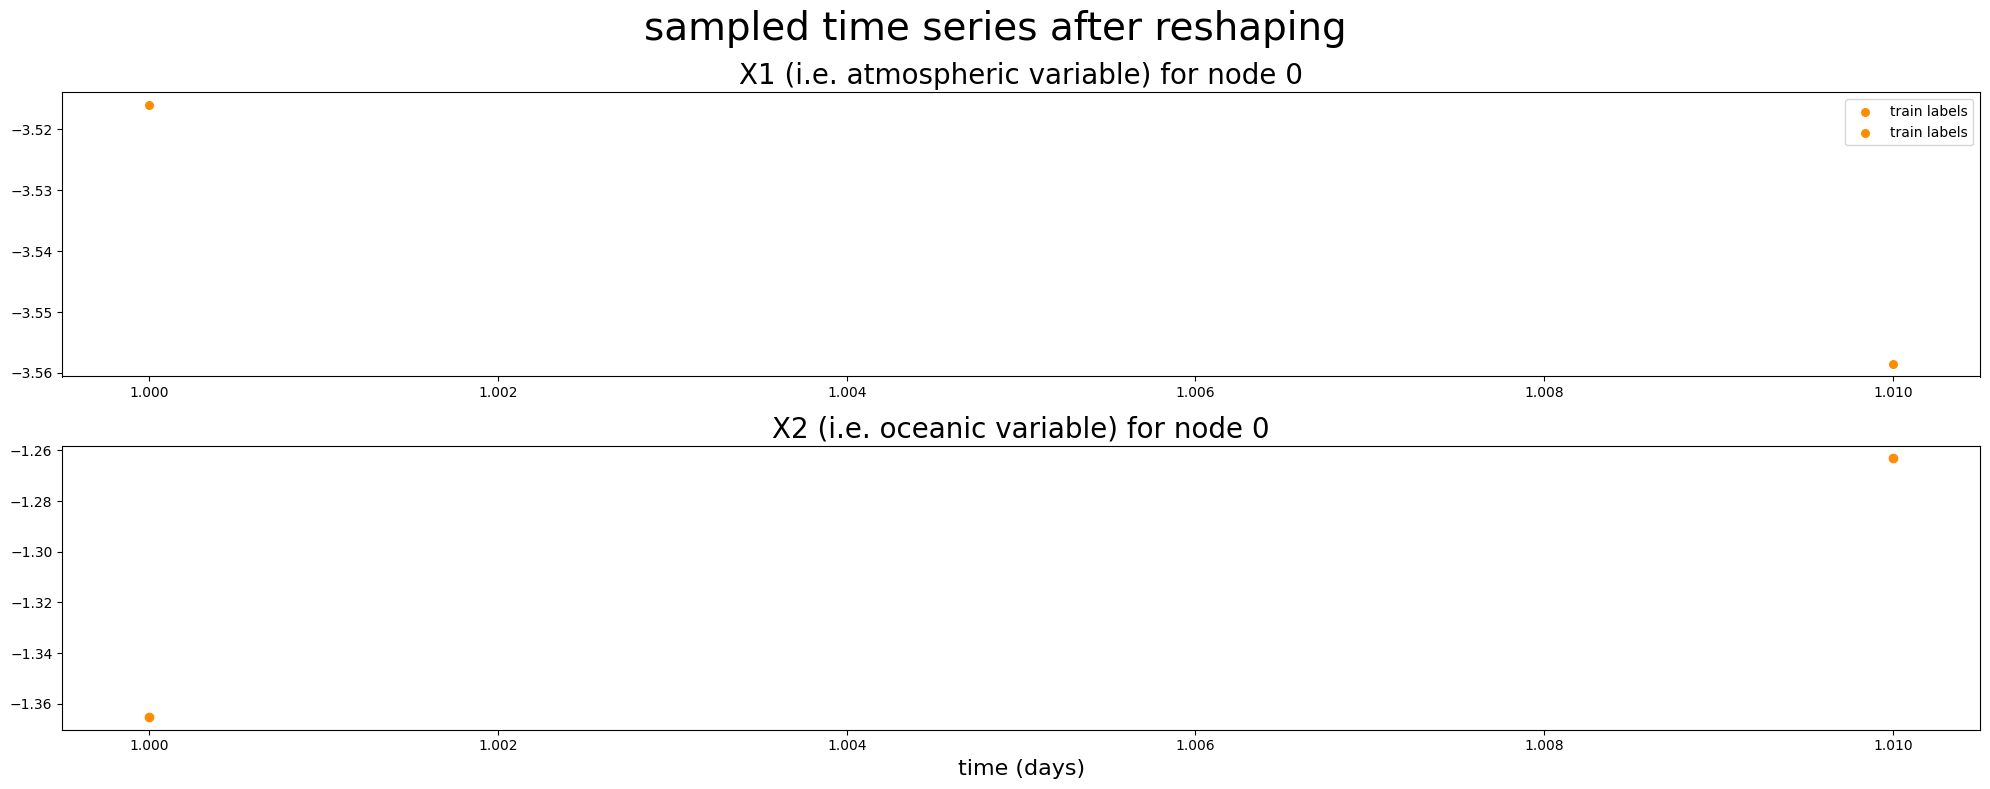

In [205]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


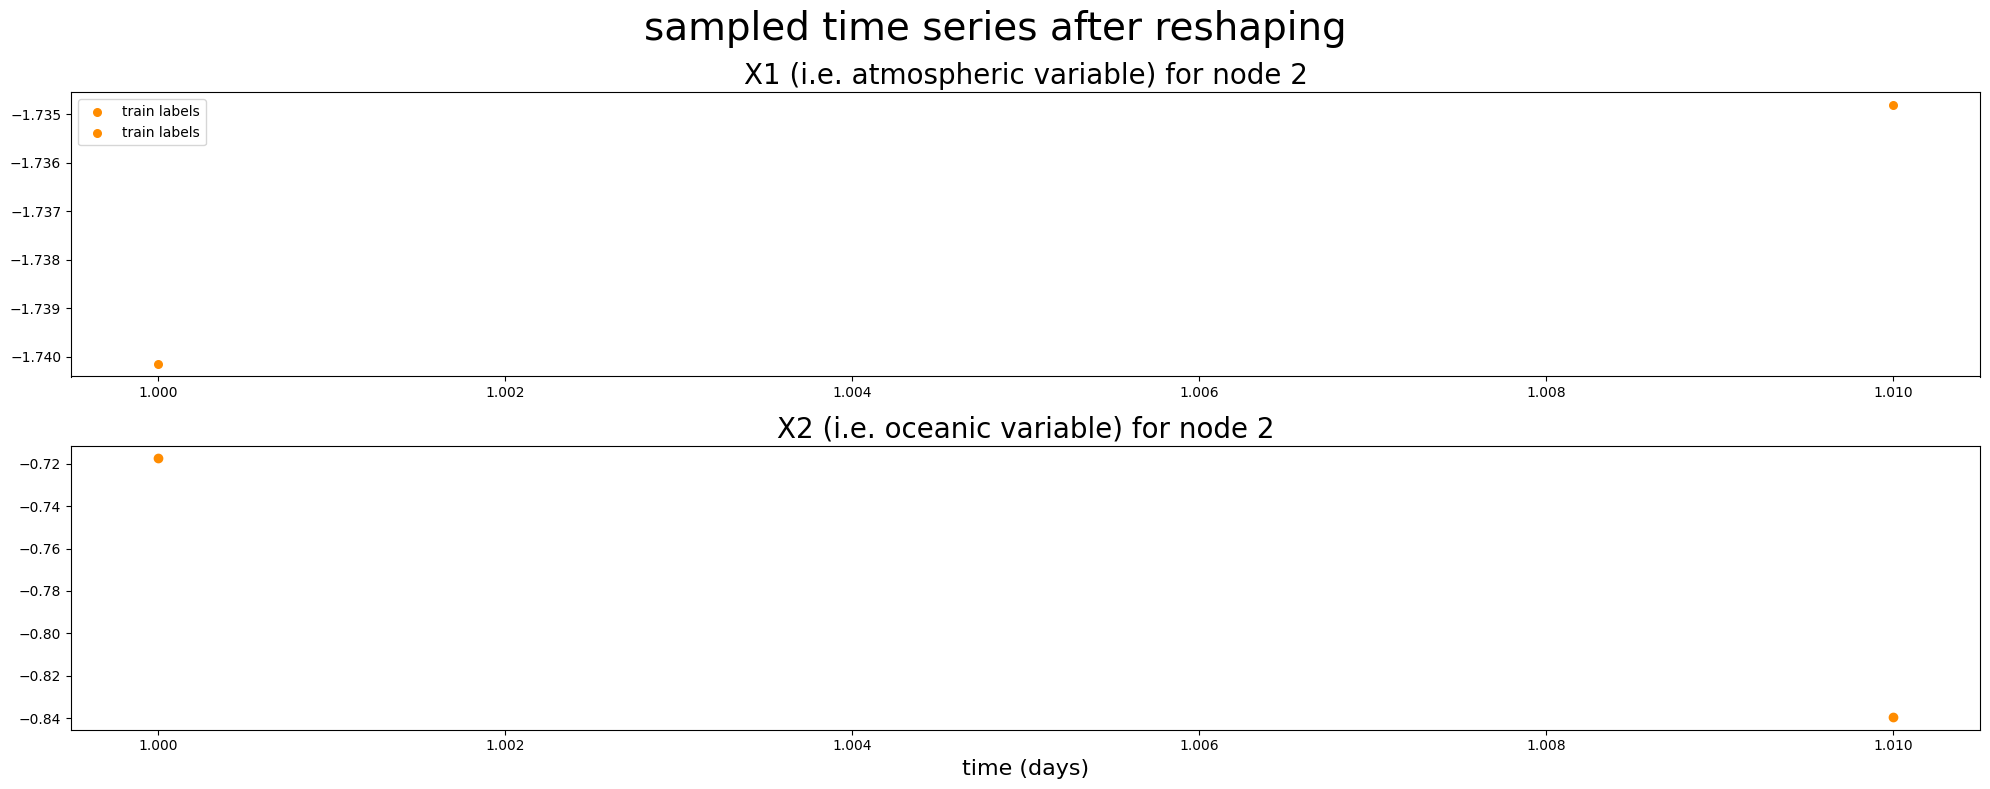

In [206]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=2, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


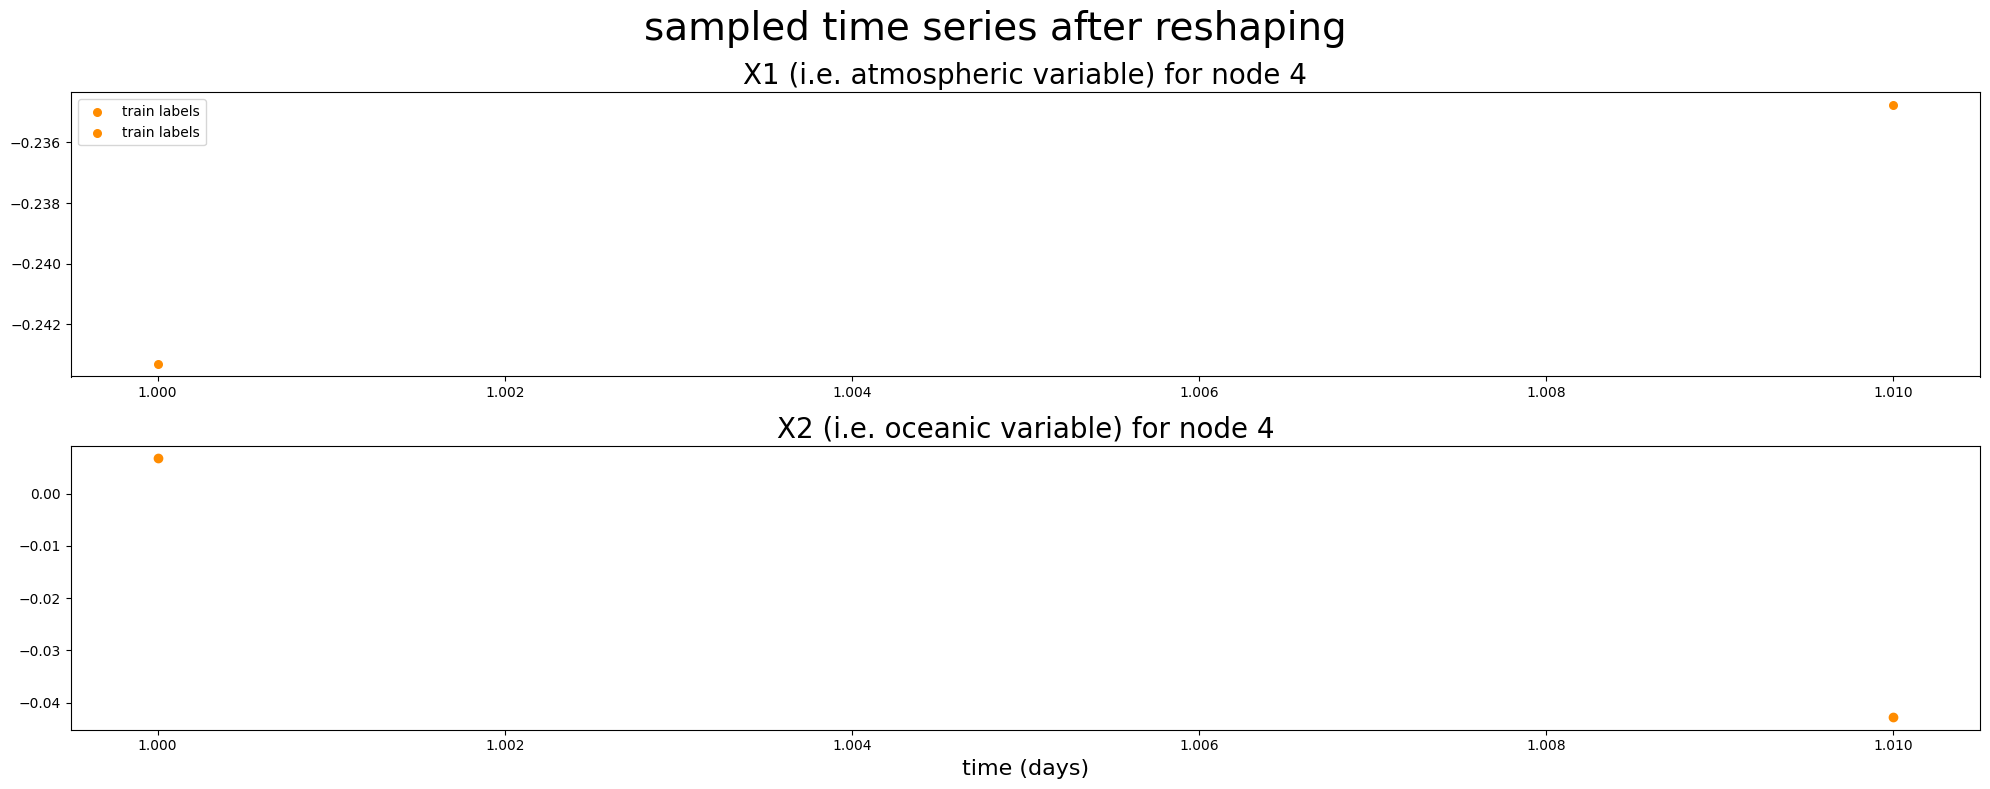

In [207]:
fig, (ax0, ax1) = plot_data(dataset_2.train, node=4, alpha=1)

plt.tight_layout()
plt.show()

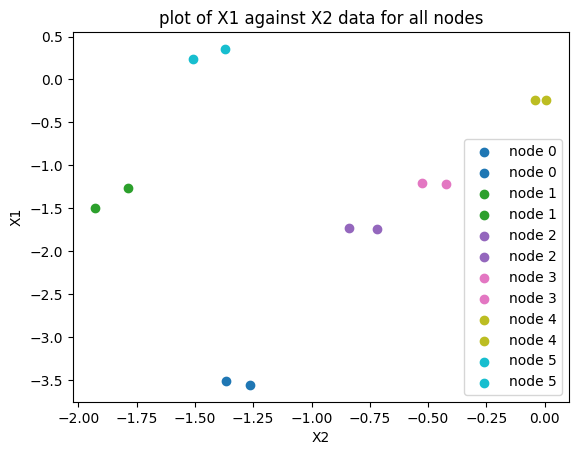

In [208]:
# plot all the X2 data against the X1 data
colors = plt.cm.tab10(np.linspace(0, 1, dataset_2.train.n_nodes))
ax = plt.subplot(1, 1, 1)

for n in range(dataset_2.train.n_nodes):
    for g in dataset_2.train:
        ax.scatter(g.x[n], g.y[n], color=colors[n], label='node {}'.format(n))

ax.set_xlabel('X2')
ax.set_ylabel('X1')
ax.set_title('plot of X1 against X2 data for all nodes')
ax.legend()

so there is very little linear correlation between X1 and X2. what if we bump up the coupling parameter? 

####  train 2-layer GCN

In [223]:
GCN_2, history_2, fname_2 = make_train_GCN(dataset_2.train,
                                           val=None,
                                           channels=32,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=500,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_18-20230227-155129/assets


INFO:tensorflow:Assets written to: saved_models/gcn_18-20230227-155129/assets


1/1 [==============================] - 0s 128ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

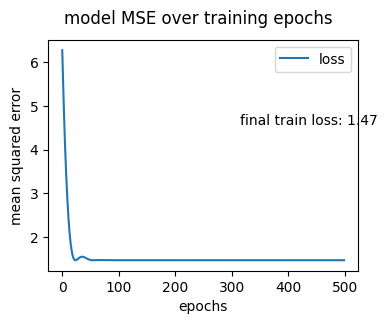

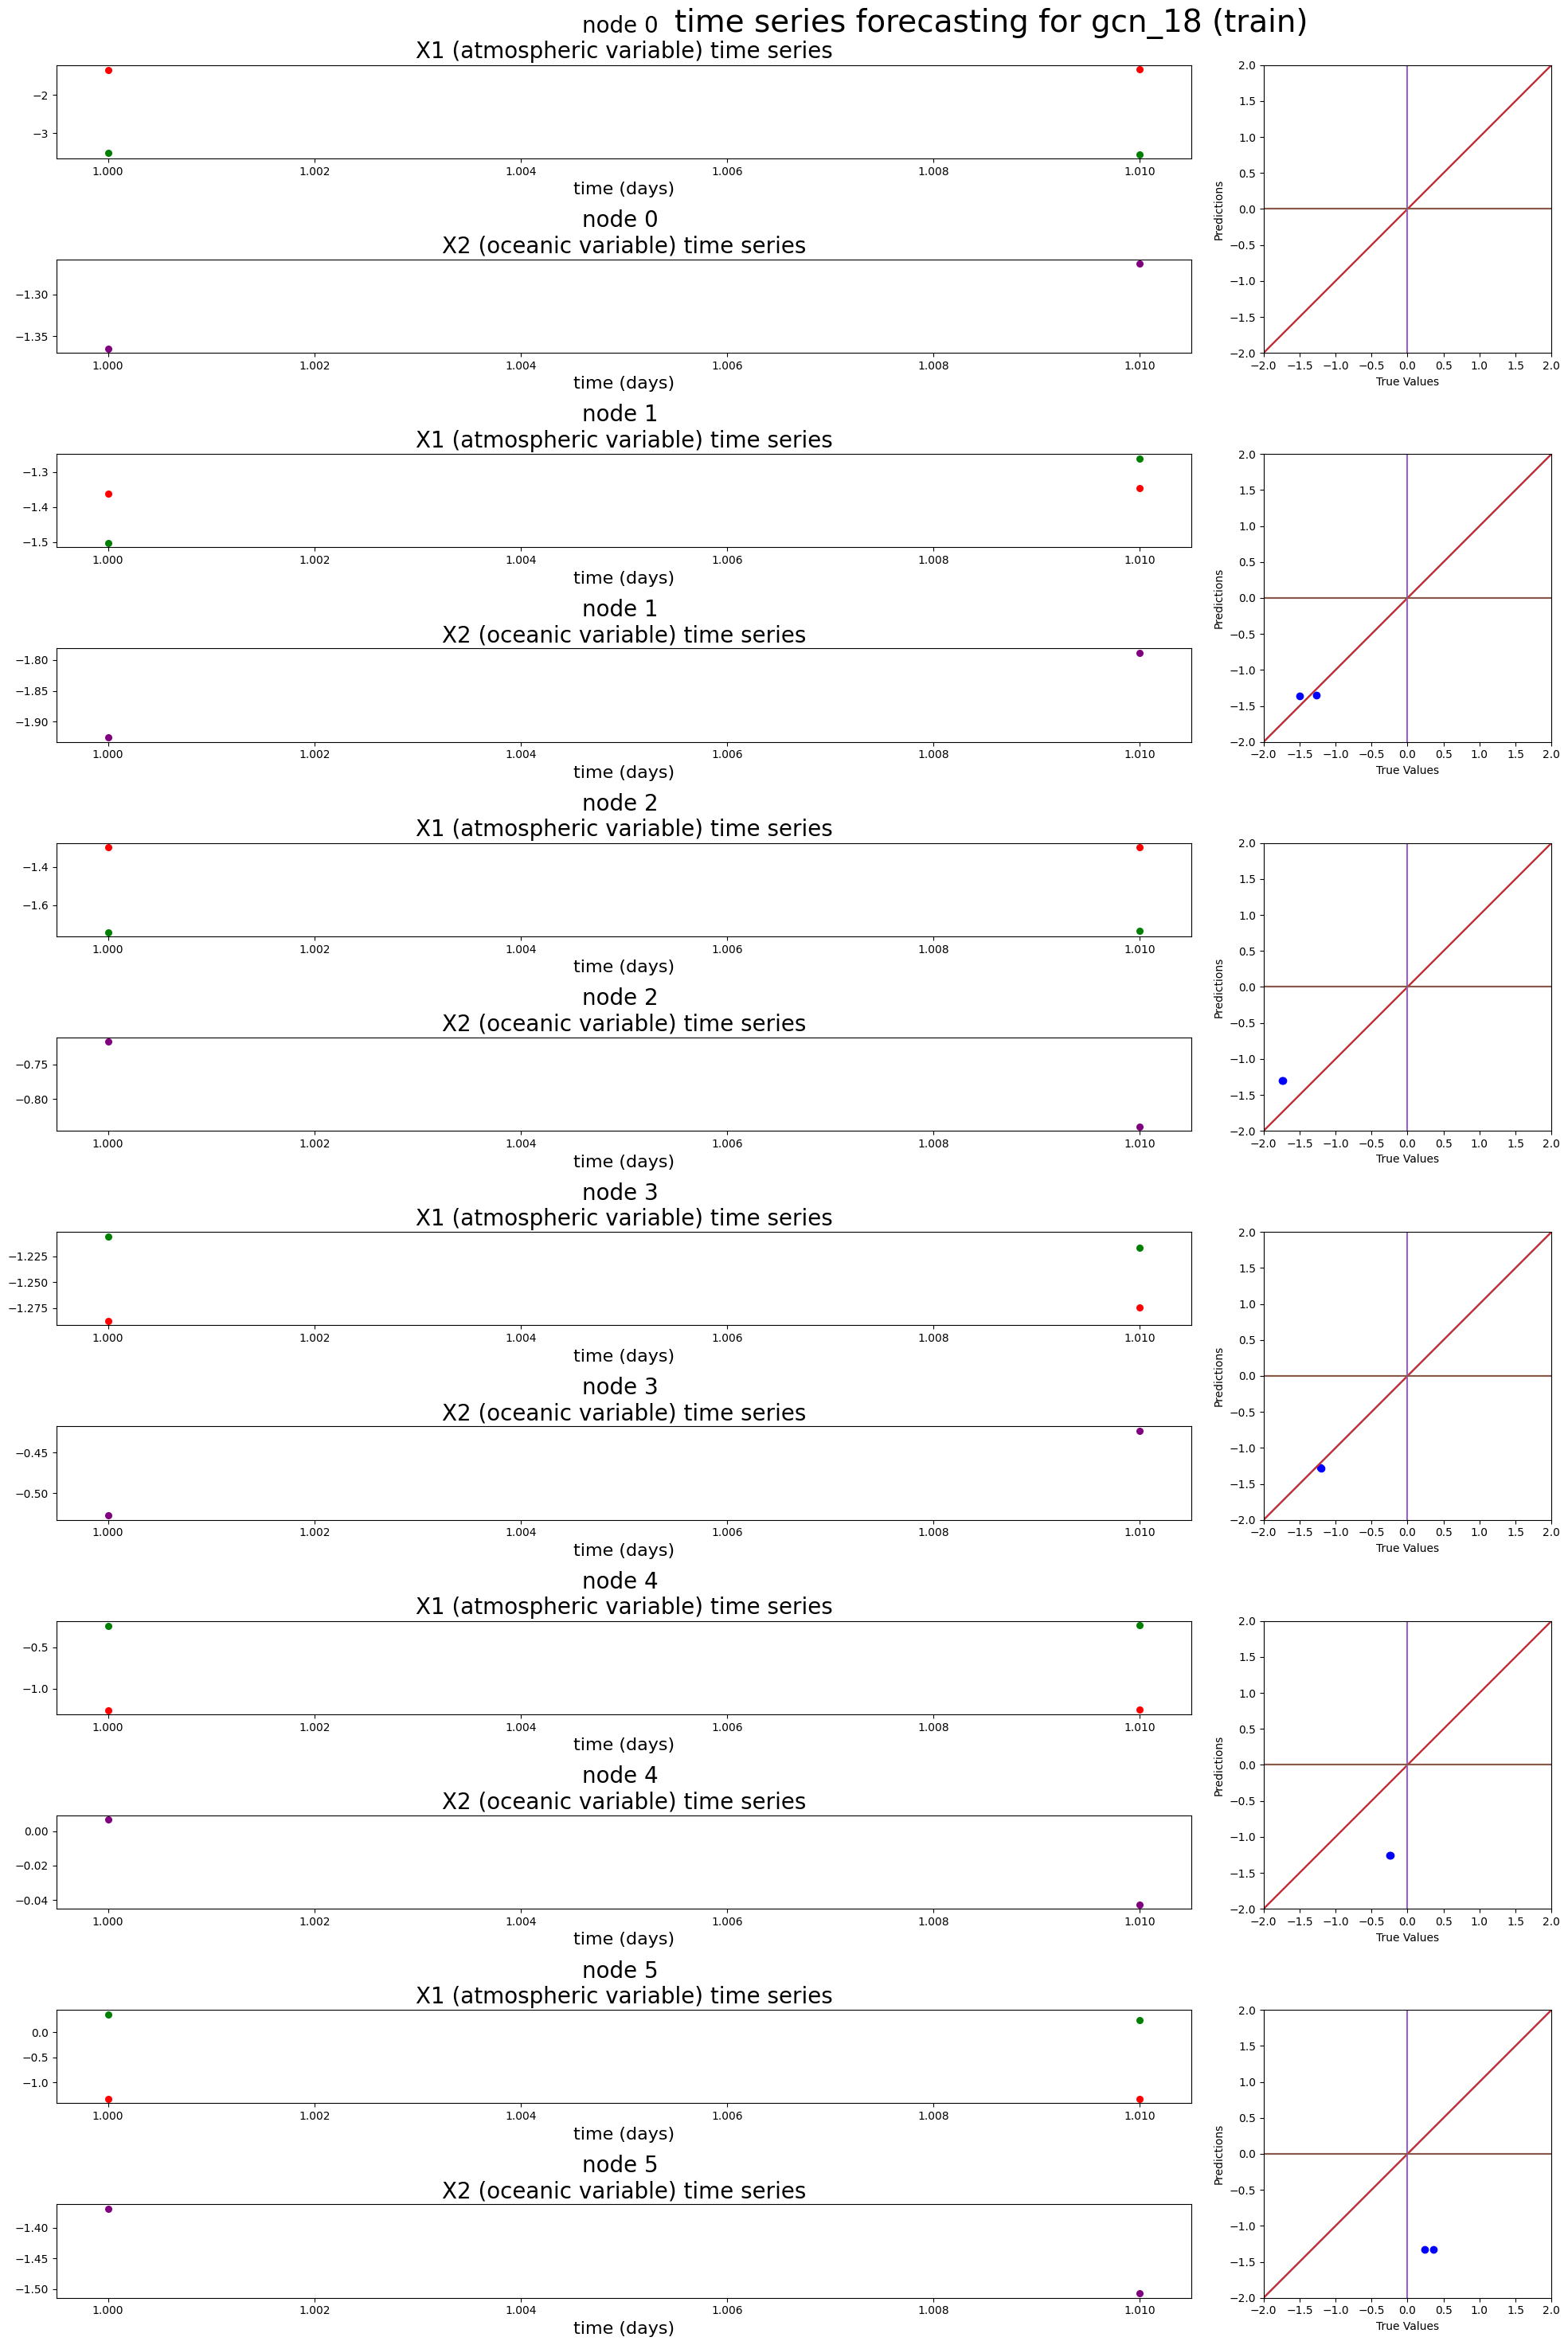

In [224]:
plot_model_results(dataset_2.train,
                   None,
                   GCN_2,
                   history_2,
                   fname_2,
                   nodes=range(6))


oops, the reason why it sucked at fitting at first was because I forgot to turn off the regularization and dropout. now it's looking slightly better, but with just 2x6 datapoints, I was expecting an MSE below 1, not something like 1.4 ...

#### train 3-layer GCN

In [227]:
GCN3_2, history3_2, fname3_2 = make_train_GCN3(dataset_2.train,
                                               val=None,
                                               channels_0=64,
                                               channels_1=32,
                                               activation="relu",
                                               dropout_rate=0,
                                               l2_reg=0,
                                               epochs=500,
                                               eval_val=False,
                                               early_stopping=False,
                                               verbose=0)


in make_train_GCN3
in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn3_5-20230227-161144/assets


INFO:tensorflow:Assets written to: saved_models/gcn3_5-20230227-161144/assets


1/1 [==============================] - 0s 269ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

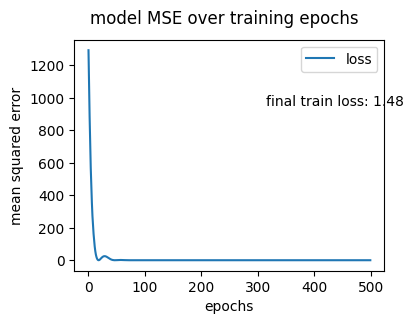

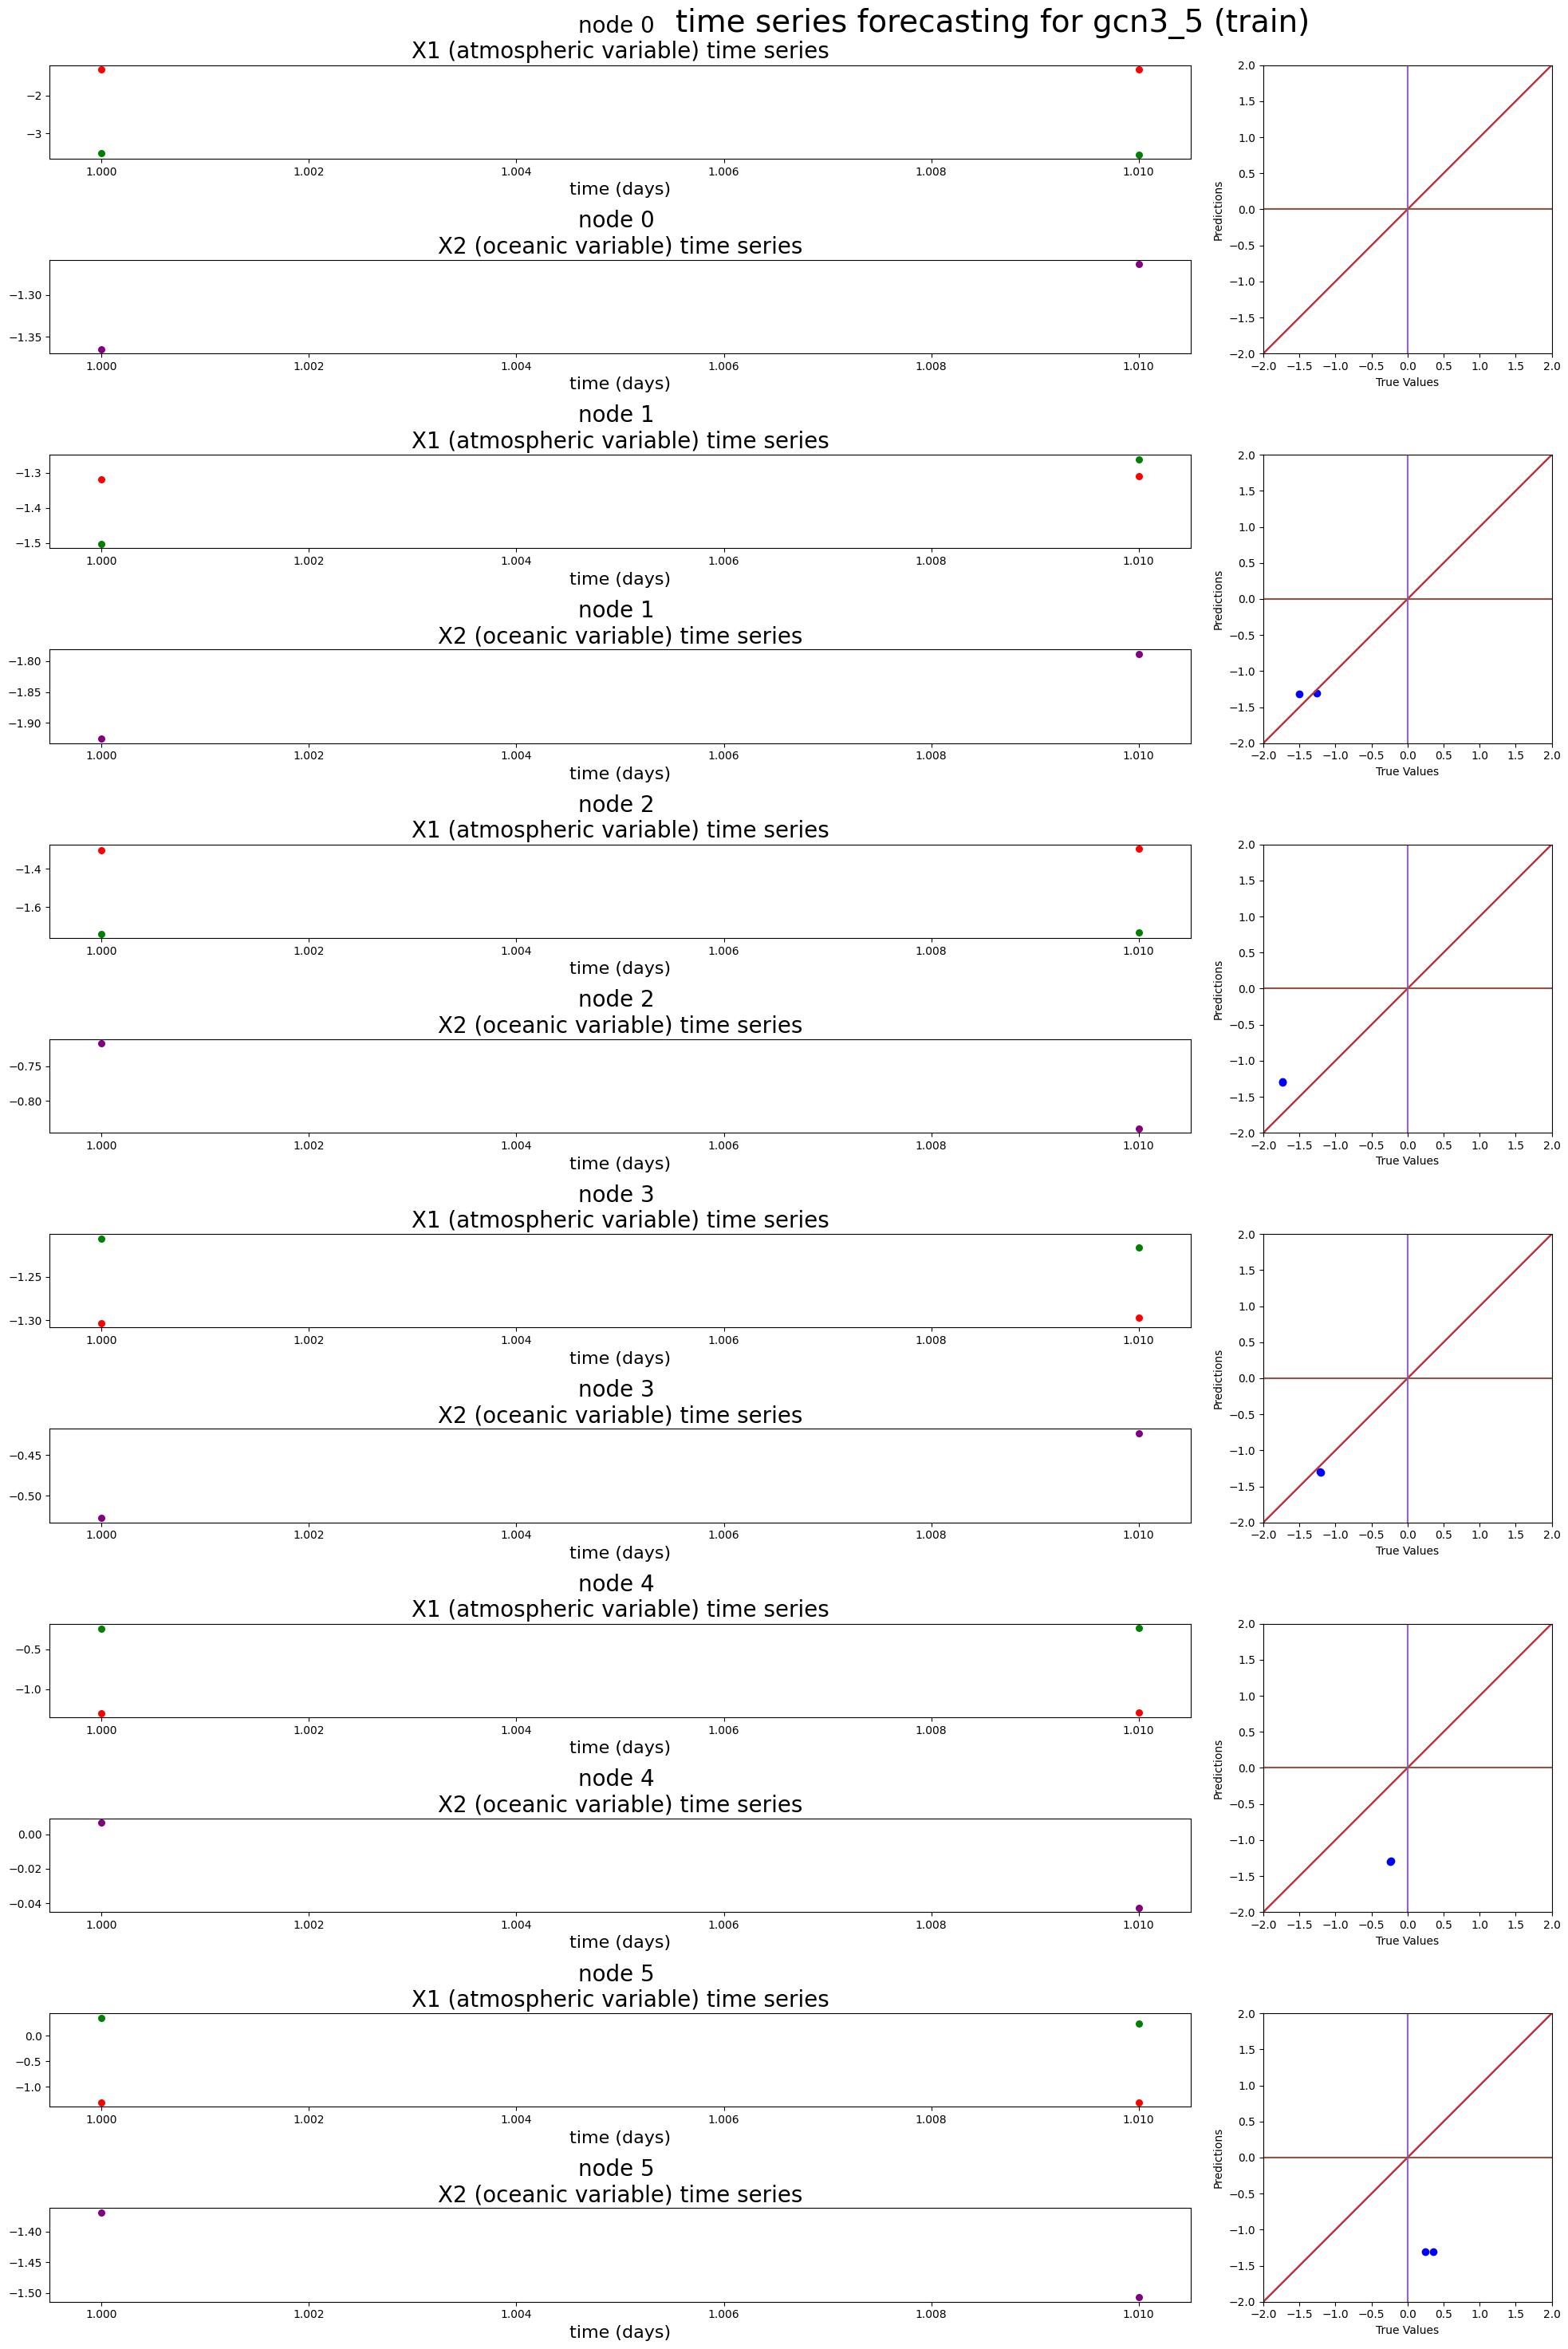

In [228]:
plot_model_results(dataset_2.train,
                   None,
                   GCN3_2,
                   history3_2,
                   fname3_2,
                   nodes=range(6))

so adding a layer to the model did not actually help the predictions. 

### 5 data points

#### prepare data

In [209]:
# only uncomment each line if testing a non-default parameter
dataset_5 = lorenzDatasetWrapper(
    predict_from="X2",
    n_samples=5,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    K=6,
    # F=8,
    # c=10,
    # b=10,
    h=0.5,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=True,
    train_pct=
    1,  # no train/val split since we have so few data points and just want to ensure overfitting right now
    val_pct=0,
    test_pct=0,
    override=True)


generating new Lorenz data and saving to file
generating paired data
starting integration
reading Lorenz data from stored file
dataset_raw lorenzDataset(n_graphs=105)
time to concat: 0:00:00.000412
time to get std&mean: 0:00:00.000129


In [210]:
dataset_5.buffer

lorenzDataset(n_graphs=100)

In [211]:
dataset_5.train

lorenzDataset(n_graphs=5)

In [212]:
dataset_5.train[0].x.flatten()

array([-1.33338982, -1.89298213, -0.68764429, -0.49805398,  0.03468759,
       -1.33735116])

In [213]:
dataset_5.train[4].x.flatten()

array([-1.24977577, -1.14090466, -1.13321254, -0.2843044 , -0.41585681,
       -1.5038772 ])

In [214]:
dataset_5.train[0].y.flatten()

array([-3.38898521, -1.42874719, -1.65974855, -1.13917475, -0.20222497,
        0.38109885])

In [215]:
dataset_5.train[4].y.flatten()

array([-3.44174104, -0.58813651, -1.49604816, -1.14549924, -0.17182086,
       -0.06594666])

inspect data

plotting train
no val data to plot
no training data to plot
editing legend


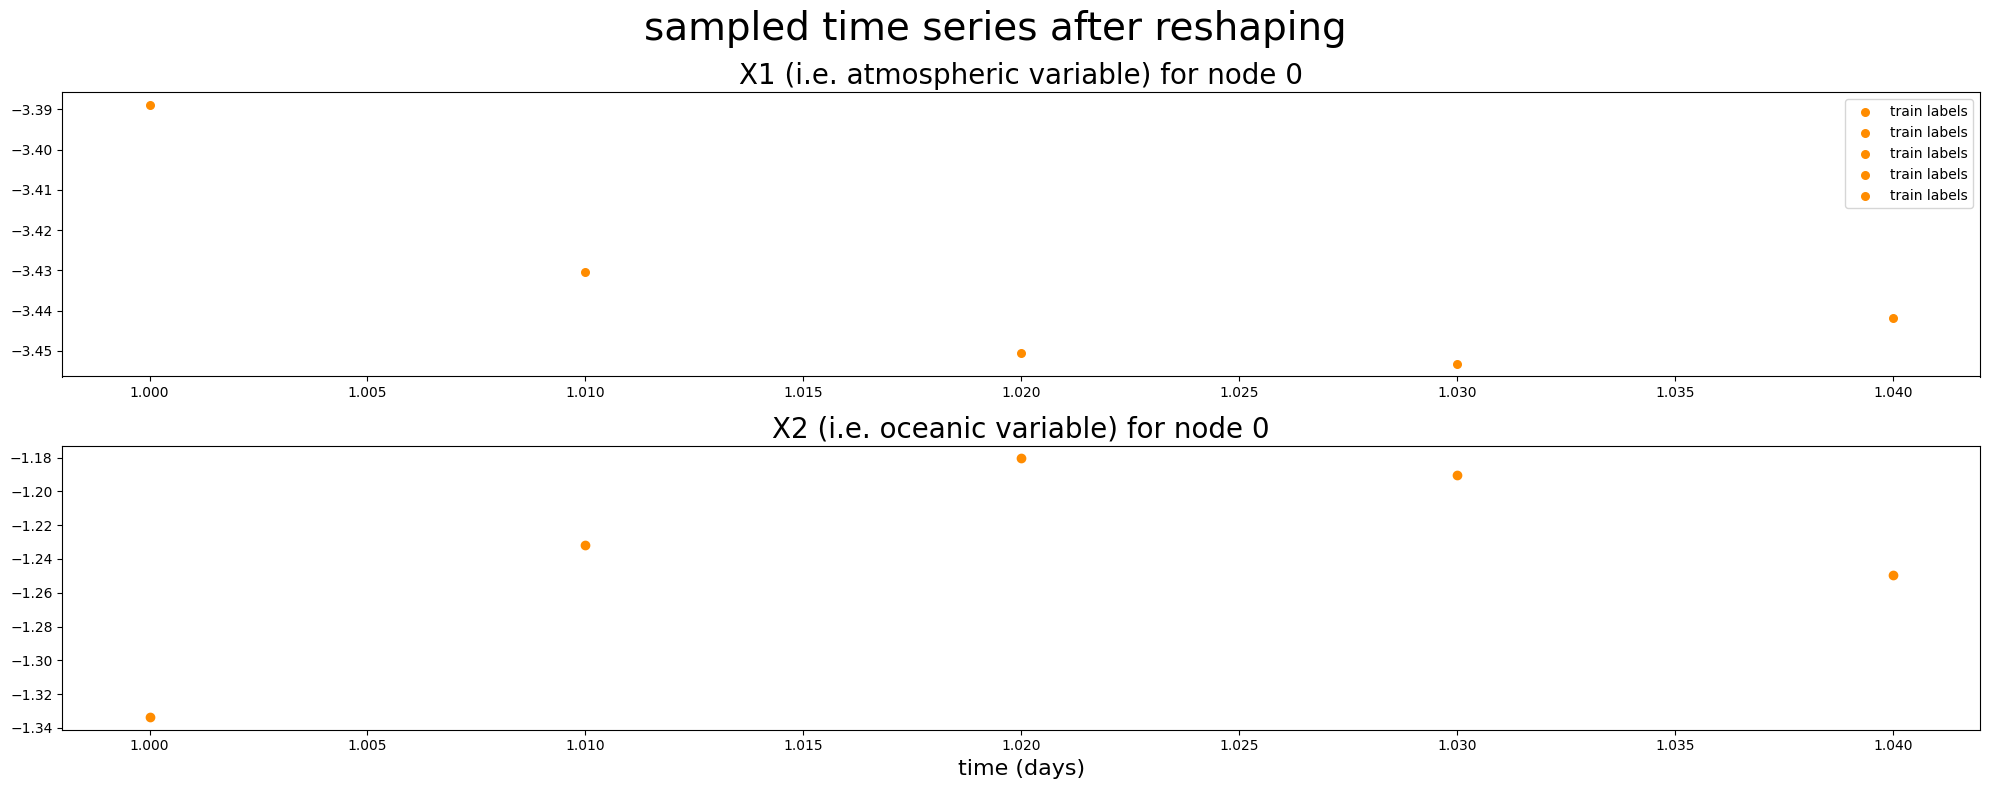

In [216]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


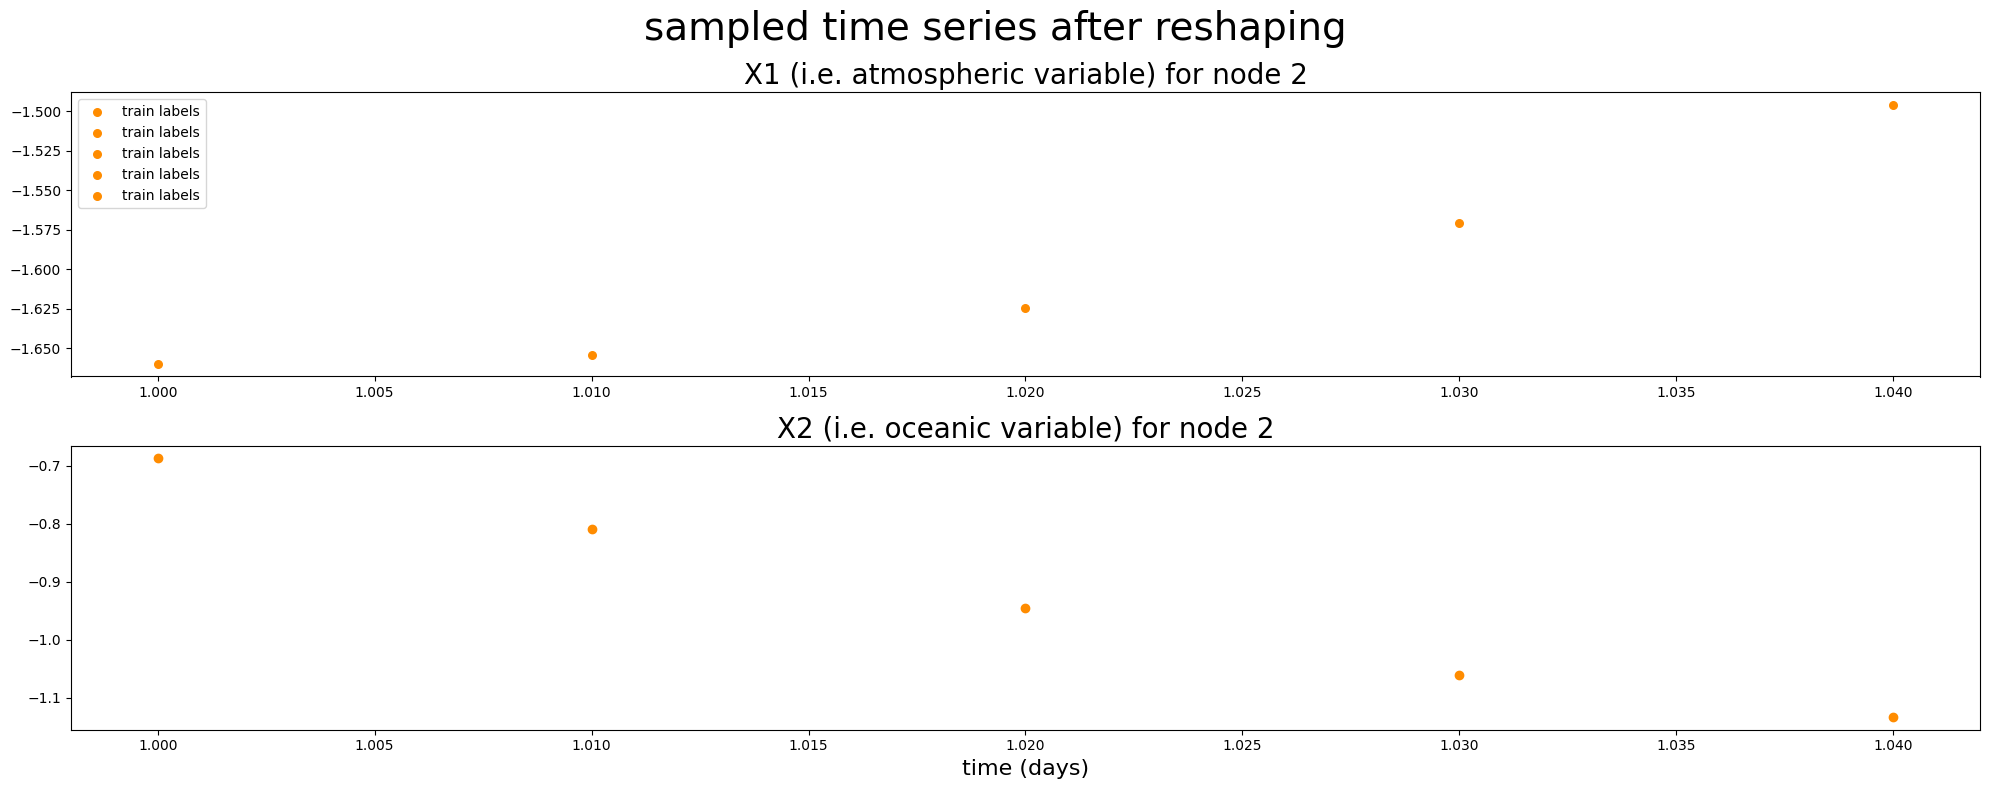

In [217]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=2, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


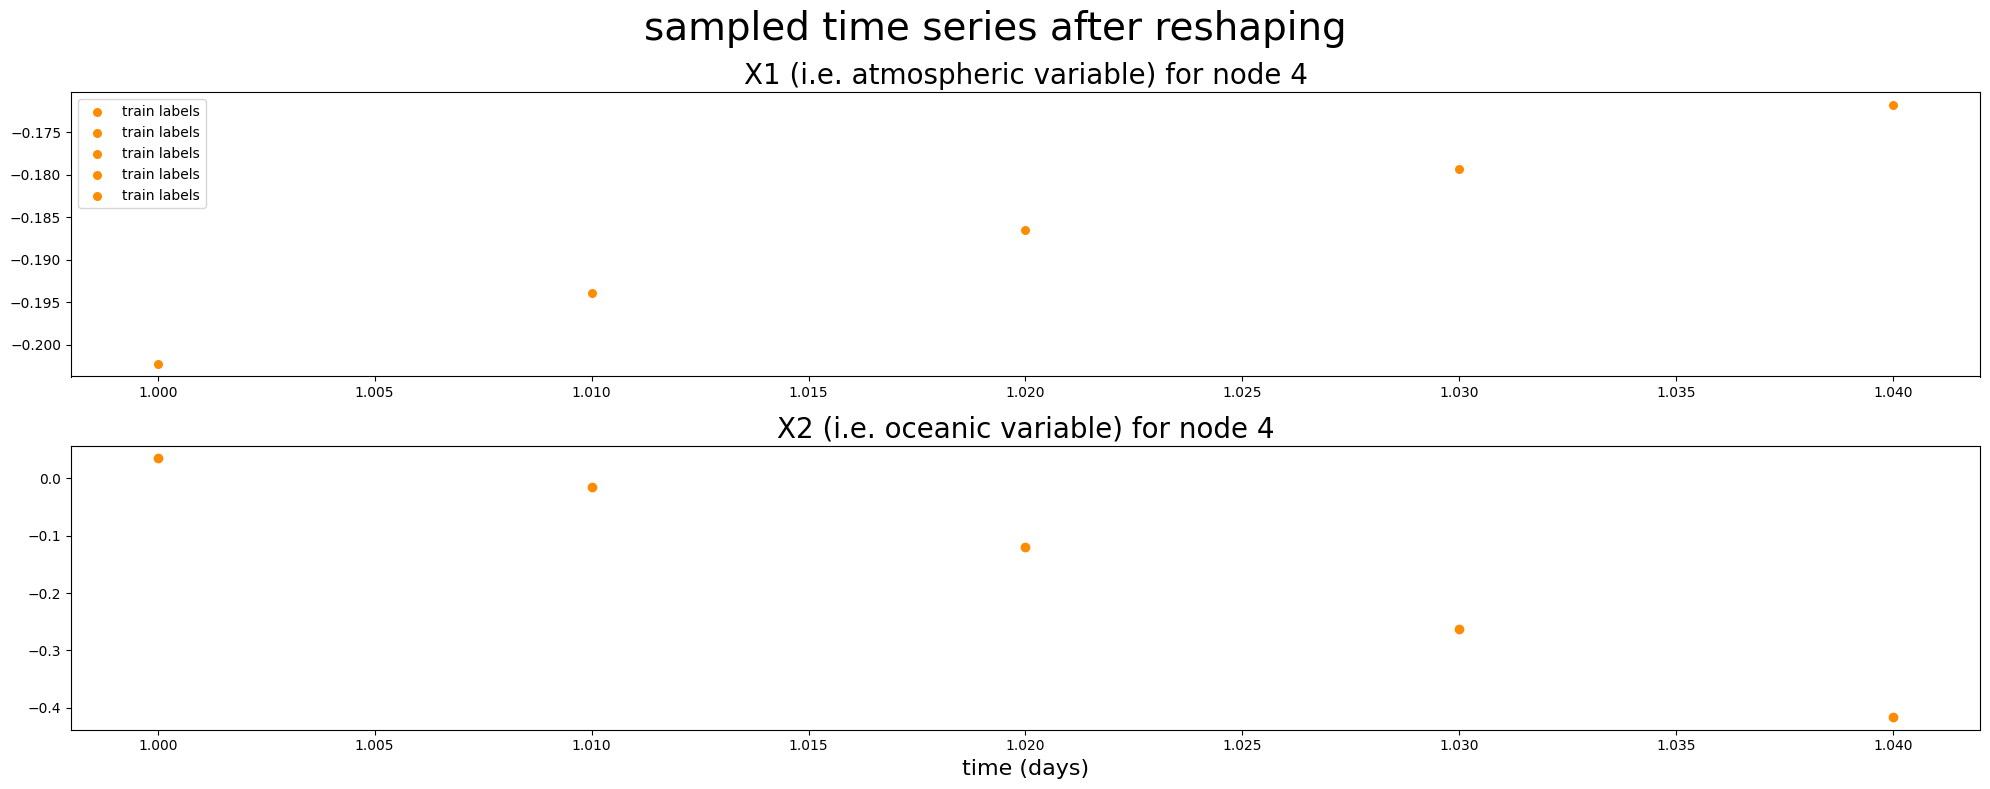

In [218]:
fig, (ax0, ax1) = plot_data(dataset_5.train, node=4, alpha=1)

plt.tight_layout()
plt.show()

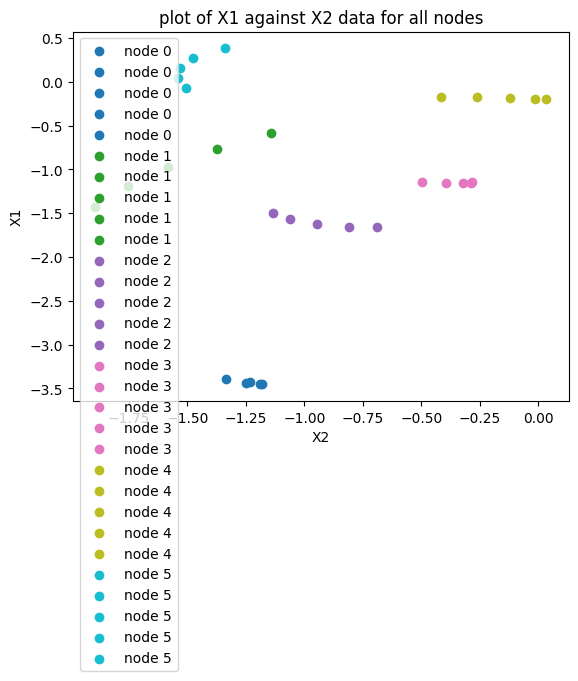

In [220]:
# plot all the X2 data against the X1 data
colors = plt.cm.tab10(np.linspace(0, 1, dataset_5.train.n_nodes))
ax = plt.subplot(1, 1, 1)

for n in range(dataset_5.train.n_nodes):
    for g in dataset_5.train:
        ax.scatter(g.x[n], g.y[n], color=colors[n], label='node {}'.format(n))

ax.set_xlabel('X2')
ax.set_ylabel('X1')
ax.set_title('plot of X1 against X2 data for all nodes')
ax.legend()

#### train 2-layer GCN

In [221]:
GCN_5, history_5, fname_5 = make_train_GCN(dataset_5.train,
                                           val=None,
                                           channels=64,
                                           activation="relu",
                                           dropout_rate=0,
                                           l2_reg=0,
                                           epochs=150,
                                           eval_val=False,
                                           early_stopping=False,
                                           verbose=0)


in train_model
compile model
fit model
saving model


INFO:tensorflow:Assets written to: saved_models/gcn_17-20230227-155116/assets


INFO:tensorflow:Assets written to: saved_models/gcn_17-20230227-155116/assets


1/1 [==============================] - 0s 127ms/step
no val data to plot


(<Figure size 400x300 with 1 Axes>, <Figure size 2500x3000 with 18 Axes>, None)

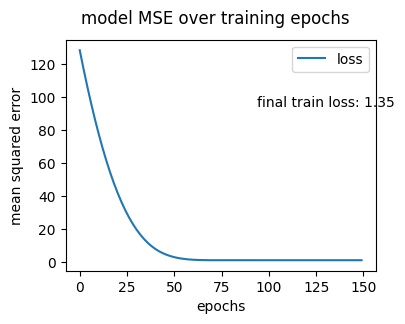

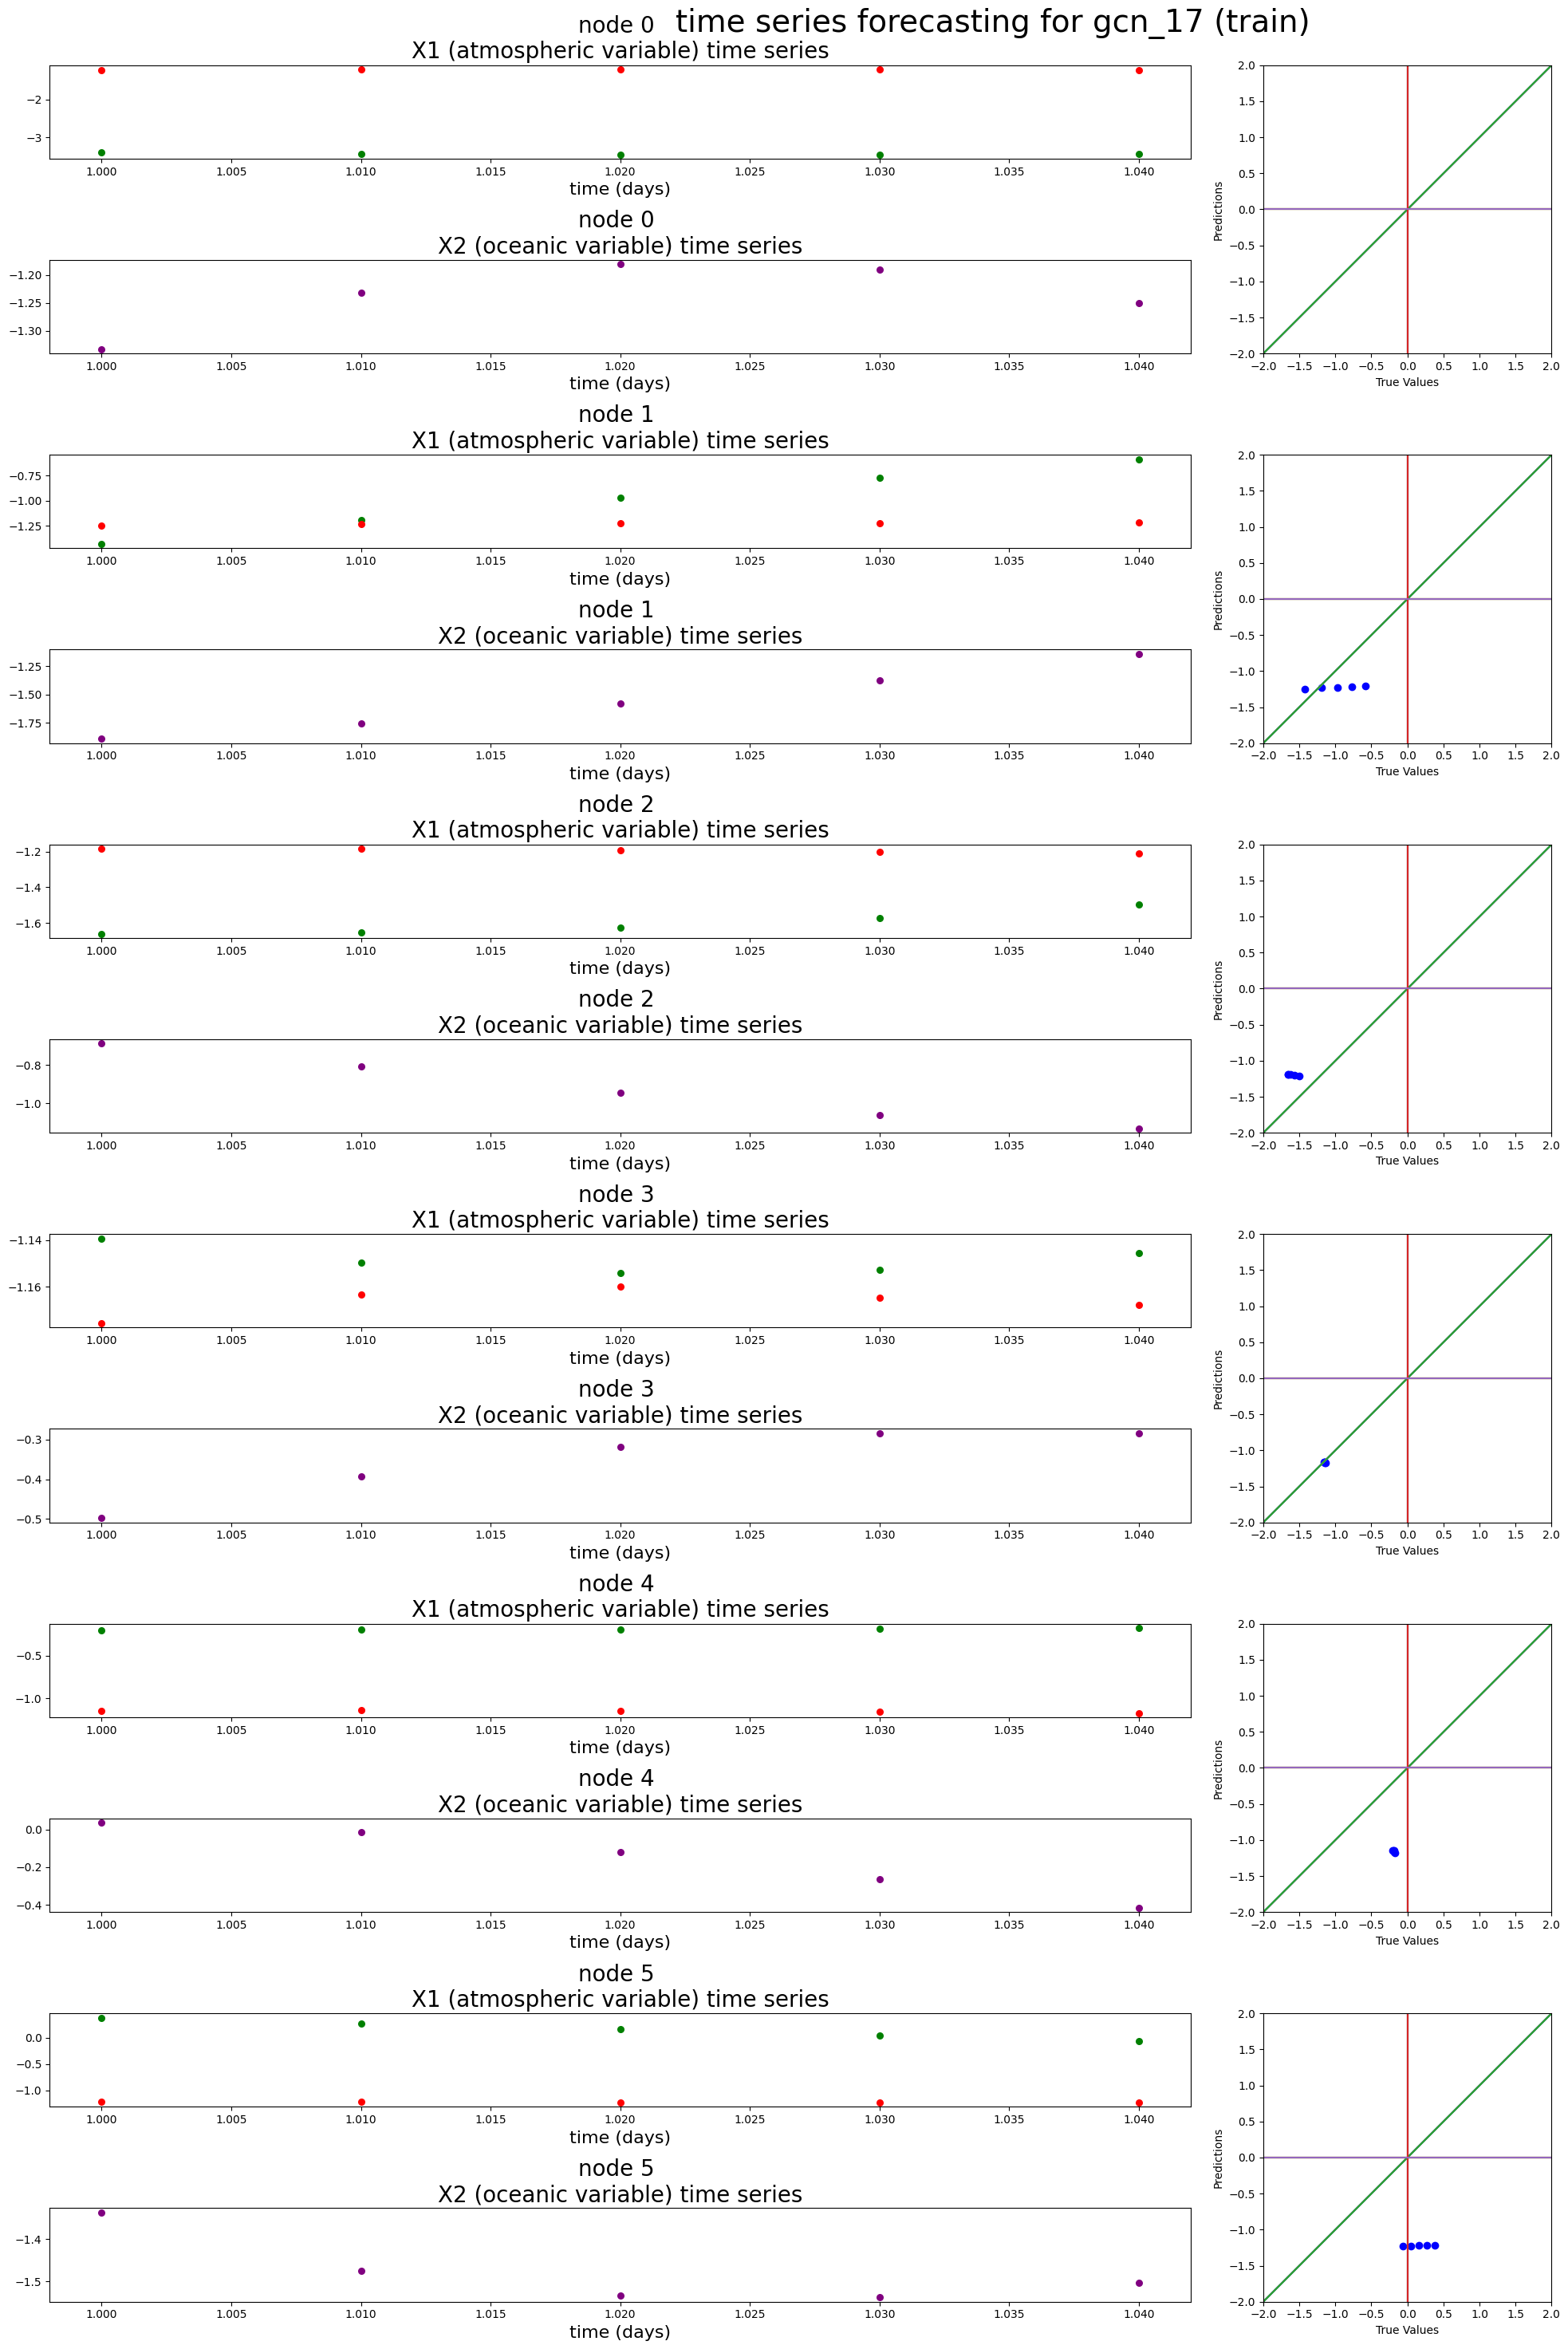

In [222]:
plot_model_results(dataset_5.train,
                   None,
                   GCN_5,
                   history_5,
                   fname_5,
                   nodes=range(6))


~~okay..... doing far worse now.....~~

how can we check what data each layer/channel of the GCN is using? we should verify that its actually using data from its neighbors. 

I think based on the Lorenz equation it also makes sense to modify the graph adjacency matrix to include connections to the second-next neighbor (i.e. the left 2 (and right 2?) neighbor nodes). 

so I think including the extra graph connections to 2nd neighbors improved performance marginally. however, the model is still behaving pretty poorly considering we're using 5 data samples. 

look at GCN layer weights